# 18 Creating Depth Maps from GemPy Models

Depth maps are an important tool for Geologists to visualize the spatial distribution of layers at depth. A simple model (Example 1) is created of which depth maps for the two existing layers are created. 

<img src="../images/tutorial18_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import gemgis as gg

file_path ='data/18_creating_depth_maps_from_gempy_models/'

C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [12]:
gg.download_gemgis_data.download_tutorial_data(filename="18_creating_depth_maps_from_gempy_models.zip", dirpath=file_path)

## Loading the data

In [3]:
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')
orientations = gpd.read_file(file_path + 'orientations.shp')
extent = [0,972,0,1069, 300, 800]
resolution = [50, 50, 50]

In [4]:
interfaces.head()

,level_0,level_1,formation,X,Y,Z,geometry
0,0,0,Sand1,0.26,264.86,353.97,POINT (0.25633 264.86215)
1,0,0,Sand1,10.59,276.73,359.04,POINT (10.59347 276.73371)
2,0,0,Sand1,17.13,289.09,364.28,POINT (17.13494 289.08982)
3,0,0,Sand1,19.15,293.31,364.99,POINT (19.15013 293.31349)
4,0,0,Sand1,27.80,310.57,372.81,POINT (27.79512 310.57169)


In [5]:
orientations['polarity'] = 1
orientations.head()

,formation,dip,azimuth,X,Y,Z,geometry,polarity
0,Ton,30.50,180.00,96.47,451.56,477.73,POINT (96.47104 451.56362),1
1,Ton,30.50,180.00,172.76,661.88,481.73,POINT (172.76101 661.87650),1
2,Ton,30.50,180.00,383.07,957.76,444.45,POINT (383.07389 957.75787),1
3,Ton,30.50,180.00,592.36,722.70,480.57,POINT (592.35583 722.70229),1
4,Ton,30.50,180.00,766.59,348.47,498.96,POINT (766.58562 348.46907),1


## Creating the GemPy Model

In [6]:
import sys  
sys.path.append('../../../../gempy-master')
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Not subsurface compatibility available


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
geo_model = gp.create_model('Model1')
geo_model

Model1  2023-03-01 12:34

### Initiating the Model

In [8]:
import pandas as pd

gp.init_data(geo_model, extent, resolution,
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


The vertices and edges are currently ``NaN`` values, so no model has been computed so far. 

In [9]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,Ton,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


### Mapping Stack to Surfaces

In [10]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#015482,1
1,Ton,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


### Loading Topography

In [13]:
geo_model.set_topography(
    source='gdal', filepath='data/18_creating_depth_maps_from_gempy_models/raster1.tif')


Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

### Setting Interpolator

In [14]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1528.90
$C_o$           55655.83
drift equations      [3]


### Computing Model

In [15]:
sol = gp.compute_model(geo_model, compute_mesh=True)

The surfaces DataFrame now contains values for vertices and edges.

In [16]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Strat_Series,1,False,False,True,True,#015482,"[[29.160000000000004, 194.27877317428587, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.26,1
1,Ton,Strat_Series,2,False,False,True,True,#9f0052,"[[29.160000000000004, 365.78652999877926, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.21,2
2,basement,Strat_Series,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3


### Plotting the 3D Model

C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\pyvista\plotting\tools.py:571: PyvistaDeprecationWarning: The usage of `parse_color` is deprecated in favor of the new `Color` class.
  warnings.warn(
C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


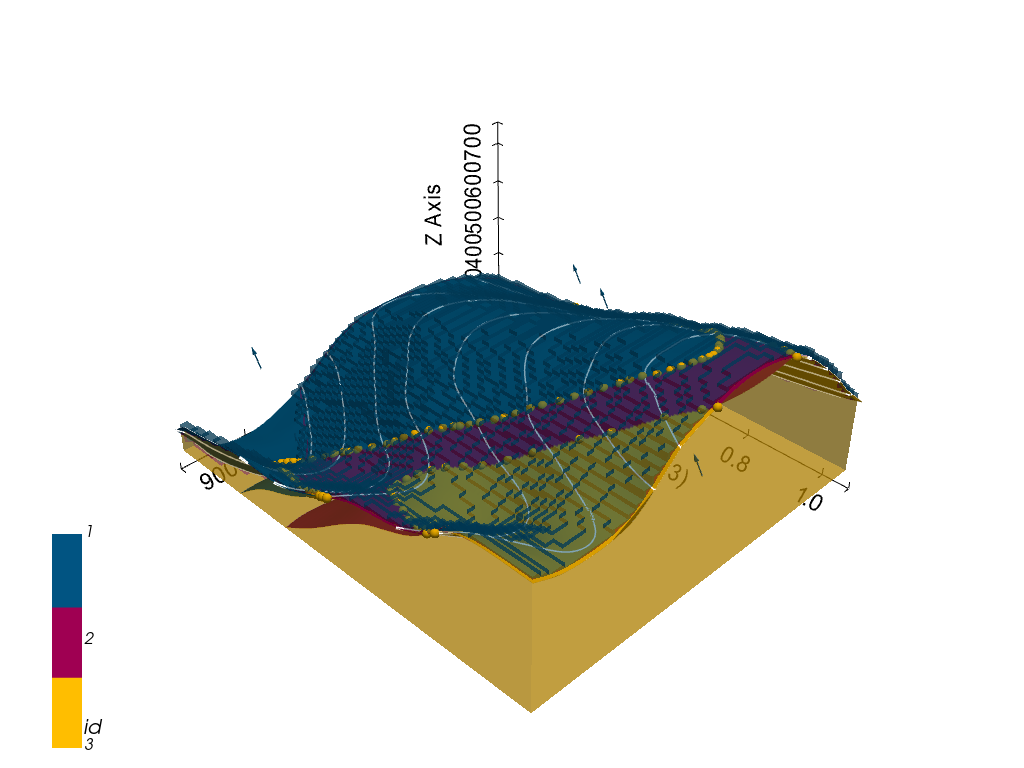

In [17]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

## Creating Depth Maps

When creating the depth maps, a dict containing the mesh, the depth values and the color of the surface within the GemPy Model are returned.

In [18]:
dict_sand1 = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model,
                                                           surfaces='Sand1')

dict_sand1

{'Sand1': [PolyData (0x24a0e712520)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	1,
  '#015482']}

In [19]:
dict_sand1['Sand1'][0]

PolyData (0x24a0e712520)
  N Cells:	4174
  N Points:	2303
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	1.881e+02, 9.491e+02
  Z Bounds:	3.050e+02, 7.250e+02
  N Arrays:	1

### Plotting Depth Maps

The depth maps can easily be plotted with PyVista.

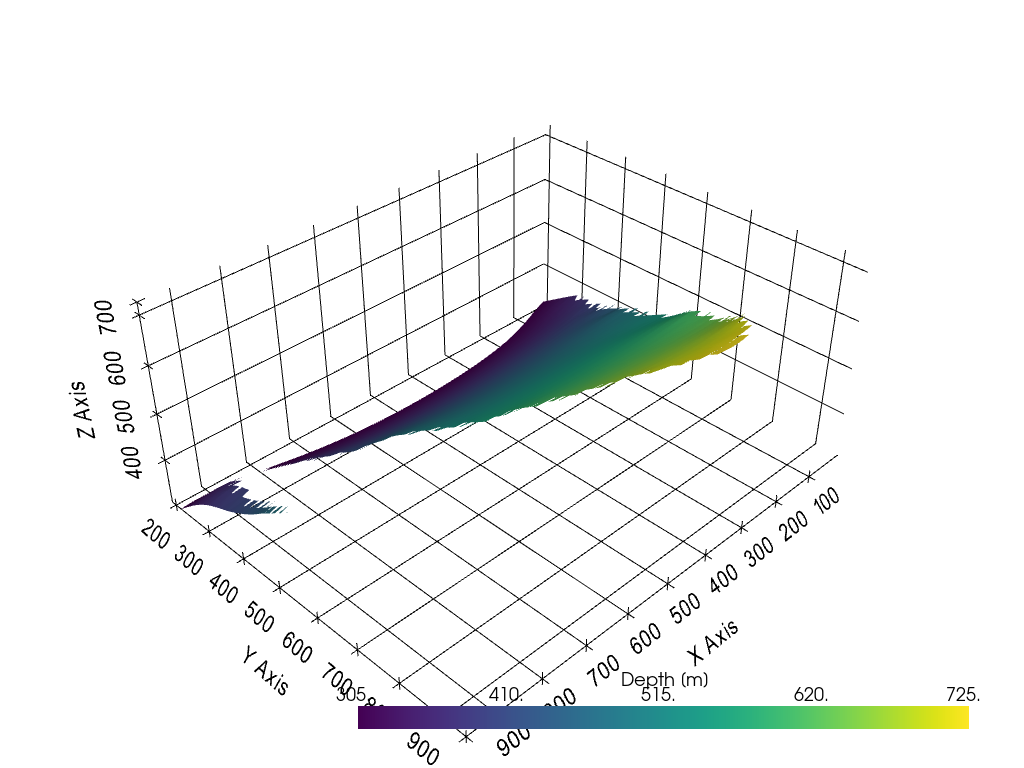

In [20]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_sand1['Sand1'][0], scalars='Depth [m]')

p.set_background('white')
p.show_grid(color='black')
p.show()

If the depth is not needed, the original GemPy Model color can also be plotted.

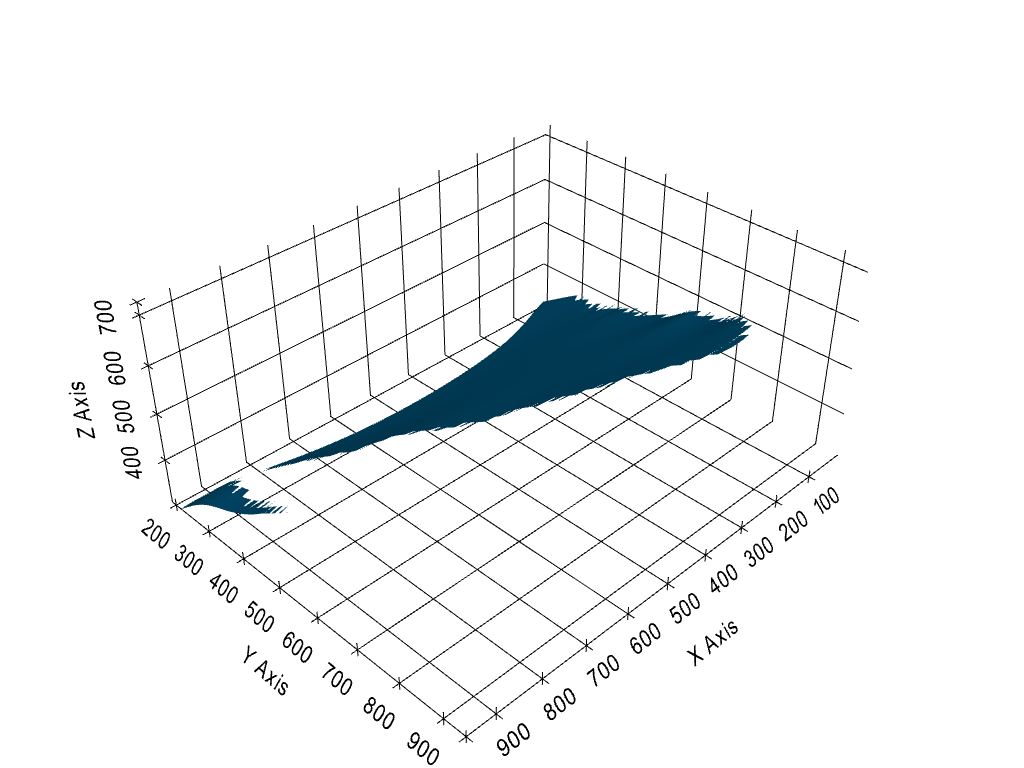

In [21]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_sand1['Sand1'][0], color=dict_sand1['Sand1'][1])

p.set_background('white')
p.show_grid(color='black')
p.show()

By providing a list of surfaces, a dict containing the data for different surfaces is created. 

In [22]:
dict_all = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model,
                                                         surfaces=['Sand1', 'Ton'])

dict_all

{'Sand1': [PolyData (0x24a134c9fa0)
    N Cells:	4174
    N Points:	2303
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.881e+02, 9.491e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	1,
  '#015482'],
 'Ton': [PolyData (0x24a137dfa00)
    N Cells:	5111
    N Points:	2739
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	3.578e+02, 1.058e+03
    Z Bounds:	3.050e+02, 7.265e+02
    N Arrays:	1,
  '#9f0052']}

In [23]:
dict_all['Sand1'][0]

PolyData (0x24a134c9fa0)
  N Cells:	4174
  N Points:	2303
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	1.881e+02, 9.491e+02
  Z Bounds:	3.050e+02, 7.250e+02
  N Arrays:	1

In [24]:
dict_all['Ton'][0]

PolyData (0x24a137dfa00)
  N Cells:	5111
  N Points:	2739
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	3.578e+02, 1.058e+03
  Z Bounds:	3.050e+02, 7.265e+02
  N Arrays:	1

This data can be accessed as before to display both surfaces.

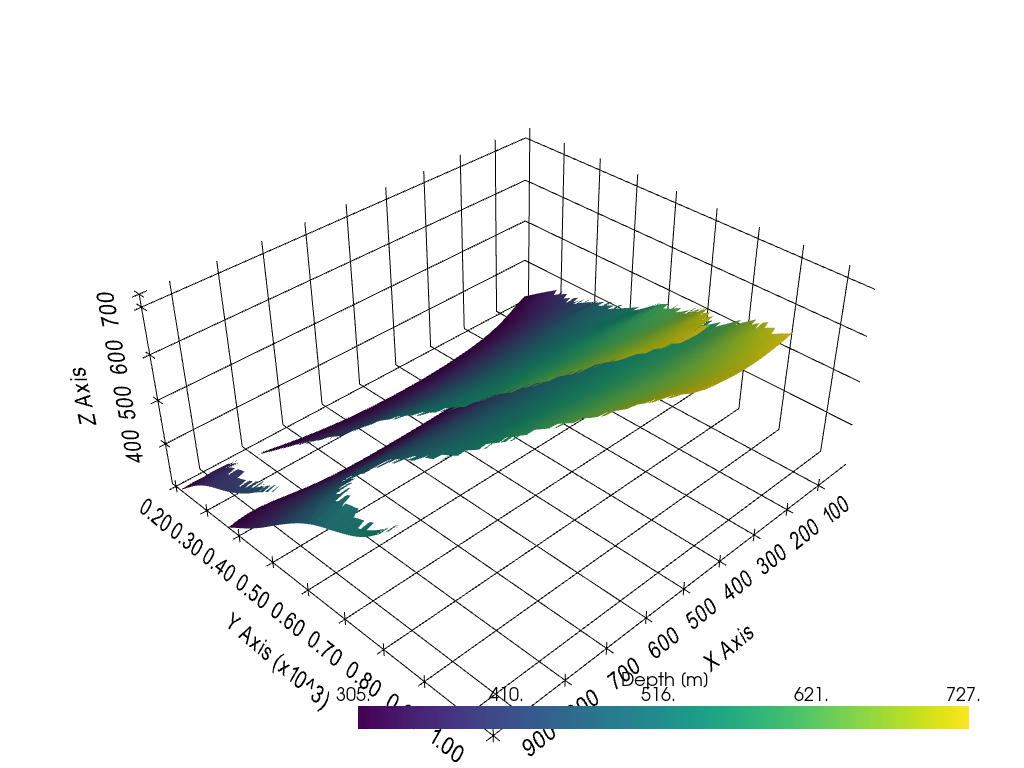

In [25]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], scalars='Depth [m]')
p.add_mesh(dict_all['Ton'][0], scalars='Depth [m]')

p.set_background('white')
p.show_grid(color='black')
p.show()

In a same way, the original colors can be used for plotting.

In [26]:
dict_all['Sand1'][0].save(file_path+'Layer1.vtk')
dict_all['Ton'][0].save(file_path+'Layer2.vtk')

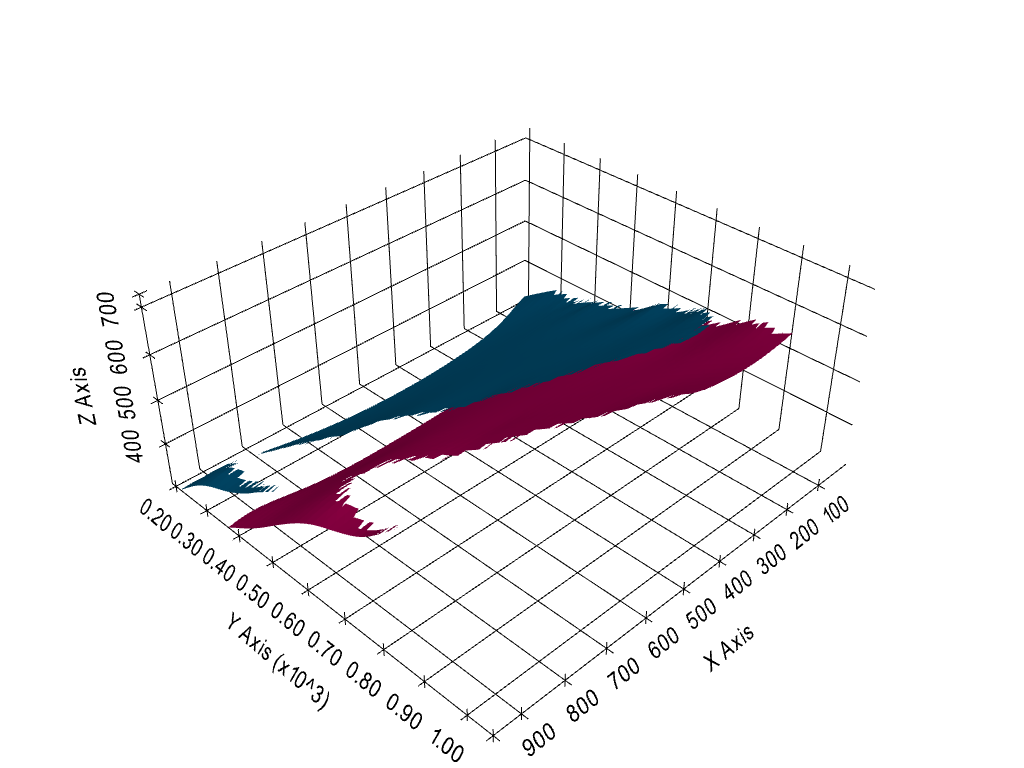

In [27]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], color=dict_all['Sand1'][1])
p.add_mesh(dict_all['Ton'][0], color=dict_all['Ton'][1])

p.set_background('white')
p.show_grid(color='black')
p.show()

### Creating depth maps from PyVista Meshes

In [28]:
dict_all['Sand1'][0]

PolyData (0x24a134c9fa0)
  N Cells:	4174
  N Points:	2303
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	1.881e+02, 9.491e+02
  Z Bounds:	3.050e+02, 7.250e+02
  N Arrays:	1

Clearing the data arrays.

In [29]:
dict_all['Sand1'][0].clear_arrays()
dict_all['Sand1'][0]

C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\pyvista\core\dataset.py:1560: PyvistaDeprecationWarning: Use of `clear_arrays` is deprecated. Use `clear_data` instead.
  warnings.warn(


PolyData,Information
N Cells,4174
N Points,2303
X Bounds,"9.720e+00, 9.623e+02"
Y Bounds,"1.881e+02, 9.491e+02"
Z Bounds,"3.050e+02, 7.250e+02"
N Arrays,0


Extracting the depth information.

In [30]:
dict_all['Sand1'][0] = gg.visualization.create_depth_map(mesh=dict_all['Sand1'][0], name='Depth [m]')
dict_all['Sand1'][0]

PolyData (0x24a134c9fa0)
  N Cells:	4174
  N Points:	2303
  X Bounds:	9.720e+00, 9.623e+02
  Y Bounds:	1.881e+02, 9.491e+02
  Z Bounds:	3.050e+02, 7.250e+02
  N Arrays:	1

Plotting the mesh again.

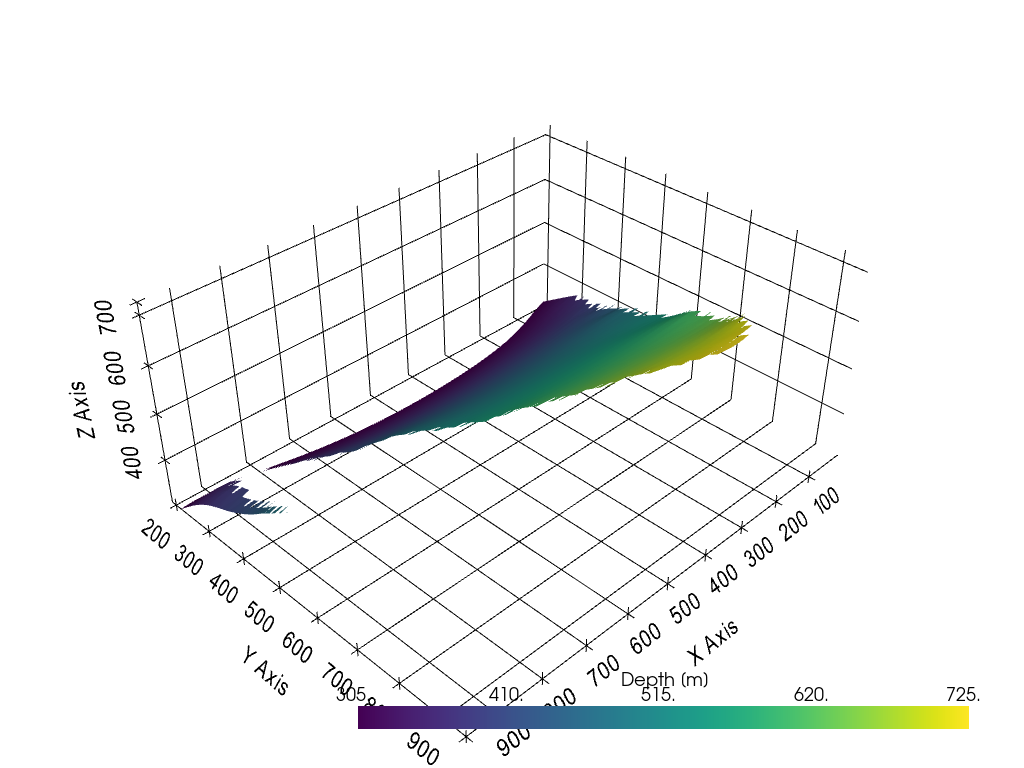

In [31]:
import pyvista as pv

p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], scalars='Depth [m]')

p.set_background('white')
p.show_grid(color='black')
p.show()

### Plotting labels to contour lines

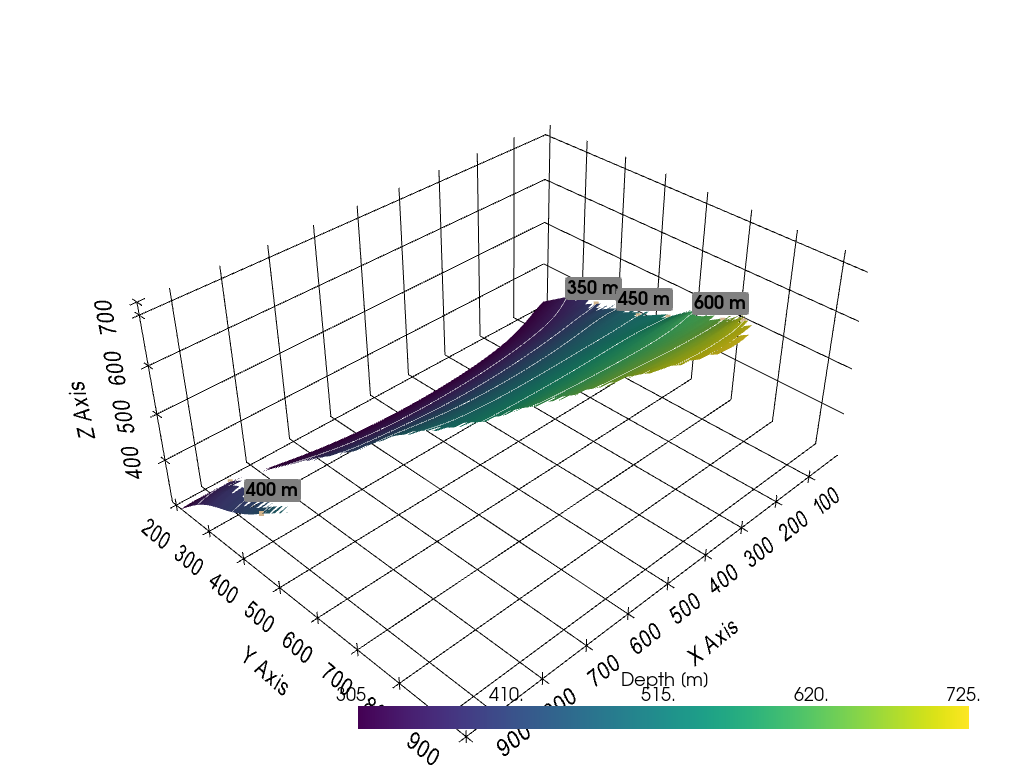

In [47]:
import numpy as np
contours = dict_all['Sand1'][0].contour(np.arange(300,750, 50))

levels = contours.split_bodies()
pts = []
values = []

for level in levels:
    pt = level.points[0]
    v = level['Depth [m]'][0]
    pts.append(pt)
    values.append(v)
    
p = pv.Plotter(notebook=True)

p.add_mesh(dict_all['Sand1'][0], scalars='Depth [m]')
p.add_point_labels(np.array(pts), [f'{v:.0f} m' for v in values])
p.add_mesh(contours, color='white')
p.set_background('white')
p.show_grid(color='black')
p.show()